In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import os
import shutil

In [2]:
# matplotlib settings to match LaTeX fonts and style
latex_path = shutil.which("latex")
print("LaTeX found at:", latex_path if latex_path else "Not found in PATH")

mpl.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "serif",  # Computer Modern serif
        "text.latex.preamble": r"\usepackage[T1]{fontenc}\usepackage{amsmath,amssymb,bm}",
        "axes.labelsize": 9,  # adjust to match \small or \normalsize
        "font.size": 9,
        "legend.fontsize": 8,
        "xtick.labelsize": 8,
        "ytick.labelsize": 8,
    }
)


def set_size(width_pt=455, fraction=1, aspect=0.62):
    """Set figure dimensions to fit LaTeX doc."""
    inches_per_pt = 1 / 72.27
    width_in = width_pt * inches_per_pt * fraction
    height_in = width_in * aspect
    return (width_in, height_in)

LaTeX found at: /Library/TeX/texbin/latex


In [3]:
def get_df(model):
    path = f"results/2d-cfno/{model}.csv"
    if not os.path.exists(path):
        return None
    df = pd.read_csv(path)
    df["model"] = model
    return df


models = ["fno-zero", "fno-full", "cfno-full"]
metric = "nrsse"

# collect all data into one big DataFrame
df = pd.concat(
    [get_df(m) for m in models],
    ignore_index=True,
)

# Prediction Error vs Ra

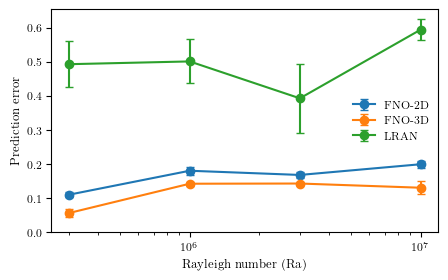

In [9]:
# TODO debug filter; filter out steps above 30
# df = df[df["step"] <= 30]
# df = df[df["ra"] >= 300000]

# 1) collapse each run (model, ra, seed) to a single scalar: mean error over all samples & timesteps
per_run = (
    df.groupby(["model", "ra", "seed"], as_index=False)[metric]
    .mean()
    .rename(columns={metric: "run_mean"})
)

# 2) aggregate across seeds (between-run variability)
summary = (
    per_run.groupby(["model", "ra"])["run_mean"]
    .agg(mu="mean", sigma="std", n_runs="count", best="min", median="median")
    .reset_index()
)

# standard error and 95% CI for convenience
# summary["se"] = summary["sigma"] / np.sqrt(summary["n_runs"]).replace(0, np.nan)
# summary["ci95"] = 1.96 * summary["se"]

# nice sort by Ra (numeric) and model
summary = summary.sort_values(["model", "ra"]).reset_index(drop=True)
fig, ax = plt.subplots(figsize=set_size(455, fraction=0.7))

for model, sub in summary.groupby("model"):
    x = sub["ra"].values
    y = sub["mu"].values
    yerr = sub["sigma"].values
    ax.errorbar(x, y, yerr=yerr, marker="o", capsize=3, label=model2name(model))

ax.set_xlabel(r"Rayleigh number ($\mathrm{Ra}$)")
ax.set_ylabel(r"Prediction error")
ax.set_xscale("log")
ax.set_ylim(bottom=0)
ax.legend(frameon=False)
fig.tight_layout(pad=0.5)

# --- Save as vector PDF for LaTeX ---
fig.savefig("figs/error_vs_ra.pdf")

# Prediction Error vs Time in Sequence

In [4]:
d = df.copy()

# 1) Per-run, per-time mean and std over samples (within-run stats)
# count is helpful for pooled std later
per_run_time = d.groupby(["model", "step"])[metric].agg(run_mean="mean").reset_index()

# 2) Aggregate across seeds at each time
across = (
    per_run_time.groupby(["model", "step"])["run_mean"]
    .agg(mu="mean", sigma="std")
    .reset_index()
    .sort_values(["model", "step"])
    .reset_index(drop=True)
)

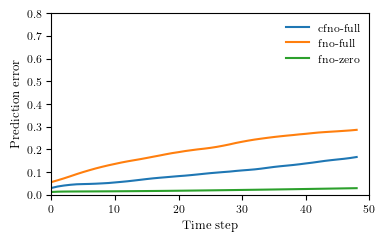

In [6]:
fig, ax = plt.subplots(figsize=set_size(455, fraction=0.6))

for model, sub in across.groupby("model"):
    x = sub["step"].values
    mu = sub["mu"].values
    sig = sub["sigma"].values
    plt.plot(x, mu, label=model)
    plt.fill_between(x, mu - sig, mu + sig, alpha=0.25)

ax.set_xlabel(r"Time step")
ax.set_ylabel(r"Prediction error")
# ax.set_title(rf"Rayleigh number ($\mathrm{{Ra}}={RA:.0e}$)")
ax.set_ylim(bottom=0, top=0.8)
ax.set_xlim(left=0, right=50)
ax.legend(frameon=False)
fig.tight_layout(pad=0.5)

# --- Save as vector PDF for LaTeX ---
fig.savefig("figs/cfno.pdf")